In [432]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from lib.Utility import exportExcelWithTimeStamp, calculateSize2, calculate_gain_full, calculateSize1, calculate_gain_quotaMin, calculate_gainHAD

from datetime import date, timedelta
import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
import numpy as np # Fundamental package for scientific computing with Python
import joblib
import plotly.express as px
from plotly import graph_objects as go
# Train the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

# features = ['B365H','B365D', 'B365A',	'B365<2.5']
features = [
    # 'HomeGoalsCumulative', 'AwayGoalsCumulative'
    # , 'HomePointsCumulative','AwayPointsCumulative',
    #  'HomeGoalsConcededCumulative',	'AwayGoalsConcededCumulative',
            #  'PointsDifference',
            #  'ConcededGoalsDifference'
            # , 'GoalsDifference',
            #  'AwayGoalsRatio'
            # , 'HomeGoalsRatio'
            #             ,'AwayGoalGap'
            # , 'HomeGoalGap',
             'AwayPointGap'
            , 'HomePointGap'
            #  , 'B365D'
              , 'B365H'
              , 'EloRatio'
            # , 'B365A'
            # , 'B365>2.5'
            ]
# features = ['HomeGoalsCumulative', 'AwayGoalsCumulative', 'AwayPointsCumulative', 'HomeGoalsConcededCumulative']
# features = ['HomeGoalsCumulative', 'AwayGoalsConcededCumulative']
# features = ['HomeGoalsCumulative', 'HomePointsCumulative']
# features = ['PointsDifference', 'HomeGoalsRatio', 'AwayPointGap', 'HomePointGap']
threshold = 0.5

In [433]:
data = pd.read_excel('data/mergedDataFull2.xlsx')
# data = pd.read_excel('data/engdata/24-25.xlsx')
# data = pd.read_excel('data/mergedDataSerieB.xlsx')
data['Cluster'] = np.where(data['FTR'] == 'H', 1, np.where(data['FTR'] == 'A', 2, 0))
# data['Cluster'] = np.where(data['FTHG'] == data['FTAG'], 1, 0) #data['FTR'].map({'D': 0, 'H': 1, 'A': 2}) 
# data = data[data['HomeGoalsCumulative'].notna()]
# data = data[data['AwayGoalsCumulative'].notna()]
# data = data[data['HomePointsCumulative'].notna()]
# data = data[data['AwayPointsCumulative'].notna()]
# data = data[data['HomeGoalsConcededCumulative'].notna()]
# data = data[data['AwayGoalsConcededCumulative'].notna()]
data = data[data['B365D'].notna()]
data = data[data['B365H'].notna()]
data = data[data['B365A'].notna()]
data['EloRatio'] = data['HomeEloRating'] / data['AwayEloRating']
# data = data[data['B365H']>1.6]
# data.dropna()
data.tail(10)

,Date,Div,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,HomeRecentHomeForm,AwayRecentAwayForm,HomeEloRating,AwayEloRating,HomePointGap,AwayPointGap,HomeGoalGap,AwayGoalGap,Cluster,EloRatio
8298,2024-04-27,E2,12:30:00,Exeter,Oxford,1,2,A,0.0,2.0,...,8.0,10.0,1507.164565,1545.911734,-13,13,-32,32,2,0.974936
8299,2024-04-27,E2,12:30:00,Fleetwood Town,Burton,3,0,H,2.0,0.0,...,8.0,4.0,1439.790918,1420.541788,-6,6,7,-7,1,1.013551
8300,2024-04-27,E2,12:30:00,Lincoln,Portsmouth,0,2,A,0.0,0.0,...,9.0,11.0,1558.623241,1636.489083,-20,20,-11,11,2,0.952419
8301,2024-04-27,E2,12:30:00,Peterboro,Bolton,3,3,D,0.0,2.0,...,7.0,6.0,1563.433578,1590.906696,-3,3,3,-3,0,0.982731
8302,2024-04-27,E2,12:30:00,Port Vale,Cambridge,0,0,D,0.0,0.0,...,4.0,4.0,1389.691652,1434.210611,-7,7,2,-2,0,0.968959
8303,2024-04-27,E2,12:30:00,Reading,Blackpool,3,2,H,1.0,1.0,...,10.0,6.0,1501.216567,1541.503824,-17,17,2,-2,1,0.973865
8304,2024-04-27,E2,12:30:00,Shrewsbury,Leyton Orient,1,3,A,0.0,2.0,...,4.0,6.0,1432.304618,1504.908613,-14,14,-16,16,2,0.951755
8305,2024-04-27,E2,12:30:00,Stevenage,Cheltenham,2,1,H,1.0,0.0,...,7.0,7.0,1516.830762,1423.683382,24,-24,15,-15,1,1.065427
8306,2024-04-27,E2,12:30:00,Wigan,Bristol Rvs,2,0,H,1.0,0.0,...,11.0,4.0,1531.293209,1453.975288,10,-10,9,-9,1,1.053177
8307,2024-04-27,E2,12:30:00,Wycombe,Charlton,1,0,H,1.0,0.0,...,10.0,6.0,1529.788848,1485.093187,9,-9,-5,5,1,1.030096


In [434]:
x_train, x_test, y_train, y_test = train_test_split(data[features], data['Cluster'], test_size= 0.3, random_state= 42,shuffle=True)

x_train = x_train.sort_index()
x_test = x_test.sort_index()
y_train= y_train.sort_index()
y_test = y_test.sort_index()

print (f'X_train: {x_train.shape} \nX_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}')


X_train: (5800, 4) 
X_test: (2487, 4) 
y_train: (5800,) 
y_test: (2487,)


In [435]:

# Set regularization rate
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
reg = 0.01

# train a logistic regression model on the training set
model1 = LogisticRegression(C=1/reg, multi_class='ovr',
                            solver="liblinear", random_state=42).fit(x_train, y_train)

from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier( random_state=42
                                , min_samples_split=100
                                , max_depth=4
                                , n_estimators=100
                                # , max_features = 'log2'
                                # ,criterion = 'entropy'
                                , class_weight = 'balanced'
                                  ).fit(x_train, y_train)
# model2 = DecisionTreeClassifier(random_state=42
#                                 , min_samples_split=100
#                                 # , class_weight={1: 1, 0: 1, 2: 1}
#                                 # , class_weight='balanced'
#                                 , max_depth=2  # , ccp_alpha= 0.00001
#                                 # , max_features= 3
#                                 ).fit(x_train, y_train)
plt.figure(figsize=(30, 20))

class_mapping = {
    0: "Draw",
    1: "Home",
    2: "Away"
}

print(model2.classes_)
# tree.plot_tree(model2, feature_names=features, filled=True, fontsize=15               # ,proportion=True  # Mostra la proporzione delle classi
#                , class_names=pd.Series(model2.classes_).map(class_mapping) #['Away', 'Home',  'Draw']
#                )
# plt.show()
# joblib.dump(model, "./Soccer-ml1.joblib")

# model = joblib.load("Soccer-ml3.joblib")

[0 1 2]


<Figure size 3000x2000 with 0 Axes>

In [436]:
# from sklearn.tree import export_graphviz
# import graphviz

# # Supponiamo che il modello sia già addestrato
# # Supponiamo di avere feature_names e class_names definite

# dot_data = export_graphviz(model, out_file=None, feature_names=features, proportion=True  # Mostra la proporzione delle classi
#                            , class_names=['Home/Away', 'Draw'], filled=True,
#                            rounded=True,
#                            special_characters=True)

# # Creare un oggetto graphviz Source
# graph = graphviz.Source(dot_data)

# # Visualizzare il grafico
# # graph.view()

# # Per salvare il grafico in un file PDF, PNG, ecc.
# # Questo salverà il grafico come "decision_tree.pdf"
# graph.render("decision_tree")

In [437]:
def custom_predict(X, threshold, model):
    probs = model.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int)
# Definisci una funzione che applica la logica descritta
def calculate_gain(row, quota_minima):
    
    if(row['predictions'] > threshold):
        if row['Cluster'] == row['predictions']:
            if row['predictions'] == 1 and row['B365H'] > quota_minima:
                return row['B365H']-1
            elif row['predictions'] == 2 and row['B365A'] > quota_minima:
                return row['B365A']-1
            elif row['predictions'] == 0 and row['B365D'] > quota_minima:
                return row['B365D']-1
        else:
            if((row['predictions'] == 0 and row['B365D'] > quota_minima) or (row['predictions'] == 2 and row['B365A'] > quota_minima) or (row['predictions'] == 1 and row['B365H'] > quota_minima)):
                return -1


def calculate_gainHAD2(row, model):
            quotaMin = 1.5
    # if row['predictions'+model] != 1:
        # if row['Cluster'] == row['predictions'+model]:
            if row['predictions'+model] == 0:
                if(row['B365D'] >= quotaMin):
                    if (row['FTR'] == 'D'):
                            return row['B365D']-1
                    else:
                        return -1
            elif row['predictions'+model] == 1:
                if(row['B365H'] <= quotaMin):
                    if (row['FTR'] == 'H'):
                        return row['B365H']-1
                    else:
                        return -1
            elif row['predictions'+model] == 2:
                if(row['B365A'] >= quotaMin):
                    if (row['FTR'] == 'A'):
                        return row['B365A']-1
                    else:
                        return -1       


In [438]:
# x_test = data[features]
# y_test = data['Cluster']

df = x_test.copy()
df['predictionsLog'] = custom_predict(x_test.sort_index(), threshold, model1)
df['predictionsDT'] = model2.predict(x_test.sort_index())
pred_prob1 = model1.predict_proba(x_test.sort_index())
pred_prob2 = model2.predict_proba(x_test.sort_index())

df2 = pd.DataFrame(pred_prob1)
df2.index = df.index
df = df.merge(df2, left_index=True, right_index=True)



finalDataset = data[data.index.isin(x_test.index)]
finalDataset = finalDataset.copy()
finalDataset['predictionsLog'] = df['predictionsLog']
finalDataset['pred_probLog'] = df[1]

df2 = pd.DataFrame(pred_prob2)
df2.index = df.index
df = df.merge(df2, left_index=True, right_index=True)

finalDataset['predictionsDT'] = df['predictionsDT']
finalDataset['pred_probDT'] = df['1_y']

finalDataset['size1'] = calculateSize1(finalDataset['B365H'], finalDataset['B365A'])
finalDataset['size2'] = calculateSize2(finalDataset['B365H'], finalDataset['B365A'])
finalDataset['gainLog1'] = np.where((finalDataset['FTR'] == 'D') & (finalDataset['pred_probLog'] > threshold),
                                finalDataset['B365D']-1, np.where((finalDataset['FTR'] != 'D') & (finalDataset['pred_probLog'] > threshold), -1, None))
finalDataset['gainLog2'] = finalDataset.apply(calculate_gain_full, axis=1, args=('Log',))
finalDataset['gainDT1'] = np.where((finalDataset['FTR'] == 'D') & (finalDataset['pred_probDT'] > threshold),
                                finalDataset['B365D']-1, np.where((finalDataset['FTR'] != 'D') & (finalDataset['pred_probDT'] > threshold), -1, None))
finalDataset['gainDT2'] = finalDataset.apply(calculate_gainHAD2, axis=1, args=('DT',))


equityDT2 = finalDataset['gainDT2'].sum()
print("EquityDT2", equityDT2)

print(f"AccuracyDT score: {round(100*accuracy_score(y_test, df['predictionsDT']),2)}%")
exportExcelWithTimeStamp(finalDataset, "Dataframe/", "df.xlsx")

EquityDT2 1014.6199999999999
AccuracyDT score: 67.99%


In [439]:
from sklearn.metrics import classification_report
# Ottieni il rapporto di classificazione
report = classification_report(y_test, df['predictionsDT'], output_dict=True)
print(report)
# Stampa l'accuratezza per ciascuna classe
for class_name, metrics in report.items():
    if class_name.isdigit():  # Verifica che si tratti di una classe e non di un aggregato (es. accuracy globale)
        print(f"Classe {class_name}: Recall (Accuratezza della classe) = {metrics['recall']:.2f}")

{'0': {'precision': 0.565947242206235, 'recall': 0.3603053435114504, 'f1-score': 0.44029850746268656, 'support': 655.0}, '1': {'precision': 0.740608228980322, 'recall': 0.8031037827352085, 'f1-score': 0.7705909725453699, 'support': 1031.0}, '2': {'precision': 0.6586134453781513, 'recall': 0.7827715355805244, 'f1-score': 0.715345122646891, 'support': 801.0}, 'accuracy': 0.6799356654603941, 'macro avg': {'precision': 0.6550563055215695, 'recall': 0.6487268872757278, 'f1-score': 0.6420782008849825, 'support': 2487.0}, 'weighted avg': {'precision': 0.6681993958470828, 'recall': 0.6799356654603941, 'f1-score': 0.66580870861379, 'support': 2487.0}}
Classe 0: Recall (Accuratezza della classe) = 0.36
Classe 1: Recall (Accuratezza della classe) = 0.80
Classe 2: Recall (Accuratezza della classe) = 0.78


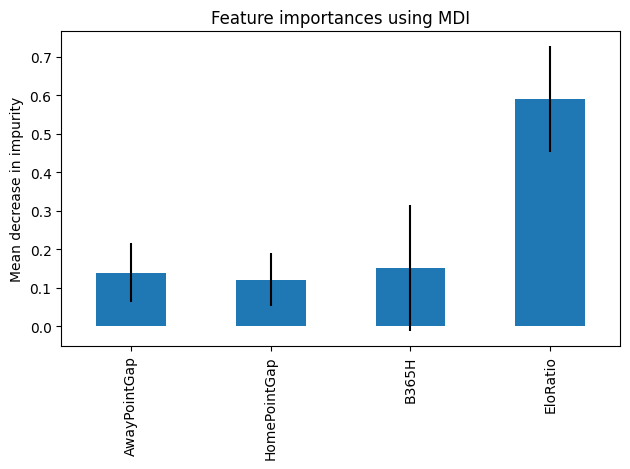

In [440]:
importances = model2.feature_importances_
std = np.std([tree.feature_importances_ for tree in model2.estimators_], axis=0)


forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [441]:
# joblib.dump(model, "./Soccer-ml7L1.joblib")